In [34]:
import pandas as pd 
import degree_codes as dc
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary, gainsChart
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
df=pd.read_csv('main_df.csv')
df.head(3)

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,INCWAGE,State,under_represented,domestic_born,EDU_verbose,is_STEM_degree,Degree,Degree_D,JobRole,stemType
0,2020,2016,202003,6676264,2016000978820,5.15,2020066762643,55,10055,1,...,51776,Wisconsin,0,1,High School,0,NaN,NaN,couriers and messengers,-1
1,2020,2016,202003,4027595,2016000661290,17.51,2020040275953,36,60036,1,...,21573,New York,0,1,High School,0,NaN,NaN,miscellaneous production workers including equ...,-1
2,2020,2017,202003,5156019,2017000181278,6.18,2020051560193,42,370142,1,...,0,Pennsylvania,0,0,Bachelor,0,Criminal Justice and Fire Protection,Criminal Justice and Fire Protection,elementary and middle school teachers,-1


In [3]:
#selecting the feautures for modeling
df_model=df[['SEX','RACE','domestic_born','EDU_verbose','is_STEM_degree','under_represented','stemType']]

In [4]:
df_model['stemType'].value_counts()

-1                                                                                 189173
Research, Development, Design, and Practitioners                                     4052
Managerial                                                                            768
Research, Development, Design, and Practitioners; Technologists and Technicians       612
Technologists and Technicians                                                         355
Sales                                                                                  39
Name: stemType, dtype: int64

In [5]:
boolian = []
for i in df_model['stemType']:
    if i == '-1':
        boolian.append(0)
    else: 
        boolian.append(1)    
    


df_model['stemType'] = pd.DataFrame(boolian, columns=['stemType'])

In [7]:
a = pd.get_dummies(df_model['RACE'], prefix = "RACE")# get dummy variables for Race
b=pd.get_dummies(df_model['EDU_verbose'],prefix='EDU_verbose')#get dummy variables for Education

frames = [df_model, a, b] # append them as a list
df_model = pd.concat(frames, axis = 1)
df_model=df_model.drop(columns = ['EDU_verbose', 'RACE']) 

In [8]:
y=df_model['stemType']
y.value_counts()

0    189173
1      5826
Name: stemType, dtype: int64

### Check for class imbalance 

Percent of 0s: 97.01

Percent of 1s: 2.99


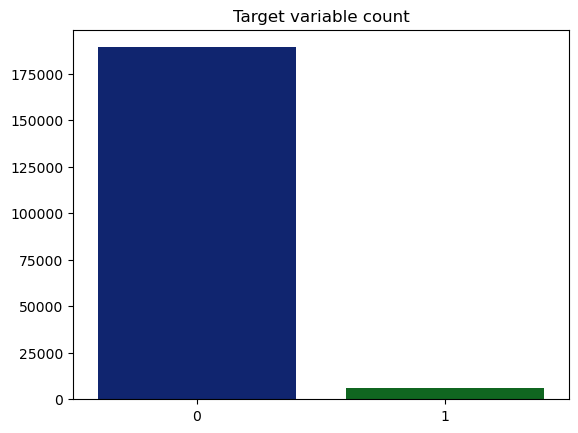

In [11]:
data = pd.DataFrame(df_model['stemType'])
percentage1 = round((data.stemType.sum() / data.shape[0]) * 100, 2) 
percentage0 = round(100 - percentage1, 2)
print('Percent of 0s:', percentage0)
print('\nPercent of 1s:', percentage1)
t=df_model['stemType'].value_counts().values
sns.barplot([0,1],t)
plt.title('Target variable count')
plt.show()

In [15]:
X = df_model.drop(columns=['stemType'])
y = df_model['stemType']
train_X, rem_X, train_y, rem_y = train_test_split(X, y, train_size=0.6, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y) 

In [16]:
print('Training Set:\n', train_y.value_counts(), '\n', train_y.value_counts(normalize = True))
print('\nValidation Set:\n', valid_y.value_counts(), '\n', valid_y.value_counts(normalize = True))
print('\nTest Set:\n', test_y.value_counts(), '\n', test_y.value_counts(normalize = True))

Training Set:
 0    113503
1      3496
Name: stemType, dtype: int64 
 0    0.970119
1    0.029881
Name: stemType, dtype: float64

Validation Set:
 0    37835
1     1165
Name: stemType, dtype: int64 
 0    0.970128
1    0.029872
Name: stemType, dtype: float64

Test Set:
 0    37835
1     1165
Name: stemType, dtype: int64 
 0    0.970128
1    0.029872
Name: stemType, dtype: float64


In [18]:
# Fixing the class imbalance with tomekLinks and SMOTE
SMOTEtl = SMOTETomek(random_state = 42)

# fit predictor and target variable for training set only
train_X_res, train_y_res = SMOTEtl.fit_resample(train_X, train_y)

print('Original dataset shape:\n', train_y.value_counts())
print('Resampled dataset shape:\n', train_y_res.value_counts())

Original dataset shape:
 0    113503
1      3496
Name: stemType, dtype: int64
Resampled dataset shape:
 0    113503
1    113503
Name: stemType, dtype: int64


### Helper Function

In [19]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y_res, model.predict(train_X_res))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

### logistic regression

In [23]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', random_state = 1)
logit_reg.fit(train_X_res, train_y_res)
confusionMatrices(logit_reg, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.7543)

       Prediction
Actual     0     1
     0 88818 24685
     1 31080 82423
Logistic regression - validation results
Confusion Matrix (Accuracy 0.7796)

       Prediction
Actual     0     1
     0 29606  8229
     1   367   798


#### Test Set

In [24]:
logit_pred = logit_reg.predict(test_X)
classificationSummary(test_y, logit_pred)

Confusion Matrix (Accuracy 0.7774)

       Prediction
Actual     0     1
     0 29479  8356
     1   324   841


### Evaluation Metrics

In [26]:
# precision tp / (tp + fp)
precision = precision_score(test_y, logit_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, logit_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, logit_pred)
print('F1 score: %f' % f1)
# ROC AUC
lr_probs = logit_reg.predict_proba(test_X)
lr_probs = lr_probs[:, 1]
auc = roc_auc_score(test_y, lr_probs)
print('ROC AUC: %f' % auc)

Precision: 0.091443
Recall: 0.721888
F1 score: 0.162324
ROC AUC: 0.824906


### Random Forest

In [36]:
RandomForest = RandomForestClassifier(n_estimators=500, random_state=1, max_depth = 6)
RandomForest.fit(train_X_res, train_y_res)
confusionMatrices(RandomForest, 'Random Forest')

Random Forest - training results
Confusion Matrix (Accuracy 0.7525)

       Prediction
Actual     0     1
     0 90052 23451
     1 32727 80776
Random Forest - validation results
Confusion Matrix (Accuracy 0.7892)

       Prediction
Actual     0     1
     0 29997  7838
     1   382   783


In [37]:
RandomForest_pred = RandomForest.predict(test_X)
classificationSummary(test_y, RandomForest_pred)

Confusion Matrix (Accuracy 0.7871)

       Prediction
Actual     0     1
     0 29869  7966
     1   339   826


In [38]:
# precision tp / (tp + fp)
precision = precision_score(test_y, RandomForest_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, RandomForest_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, RandomForest_pred)
print('F1 score: %f' % f1)
# ROC AUC
rf_probs = RandomForest.predict_proba(test_X)
rf_probs = rf_probs[:, 1]
auc = roc_auc_score(test_y, rf_probs)
print('ROC AUC: %f' % auc)

Precision: 0.093949
Recall: 0.709013
F1 score: 0.165913
ROC AUC: 0.822435


### Neural Network

In [30]:
neuralNet = MLPClassifier(hidden_layer_sizes=(5), activation='logistic', solver='lbfgs', max_iter=2000, 
                          random_state=1)
neuralNet.fit(train_X_res, train_y_res)
confusionMatrices(neuralNet, 'Neural Network')

Neural Network - training results
Confusion Matrix (Accuracy 0.7561)

       Prediction
Actual     0     1
     0 89362 24141
     1 31221 82282
Neural Network - validation results
Confusion Matrix (Accuracy 0.7829)

       Prediction
Actual     0     1
     0 29748  8087
     1   378   787


In [31]:
neuralNet_pred = neuralNet.predict(test_X)
classificationSummary(test_y, neuralNet_pred )

Confusion Matrix (Accuracy 0.7824)

       Prediction
Actual     0     1
     0 29671  8164
     1   324   841


In [32]:
# precision tp / (tp + fp)
precision = precision_score(test_y, neuralNet_pred )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, neuralNet_pred )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, neuralNet_pred )
print('F1 score: %f' % f1)
# ROC AUC
nn_probs = neuralNet.predict_proba(test_X)
nn_probs = nn_probs[:, 1]
auc = roc_auc_score(test_y, nn_probs)
print('ROC AUC: %f' % auc)

Precision: 0.093393
Recall: 0.721888
F1 score: 0.165388
ROC AUC: 0.823494


In [39]:
table = {'Models':["Logistic Regression", 
                   "Random Forest",
                   "Neural Network"],
         'Accuracy':[accuracy_score(test_y, logit_pred),
                     
                     accuracy_score(test_y, RandomForest_pred),
                     
                     accuracy_score(test_y, neuralNet_pred)],
         'Precision':[precision_score(test_y, logit_pred),
                   
                 
                      precision_score(test_y, RandomForest_pred),
                      
                      precision_score(test_y, neuralNet_pred) ],
         "Recall":[recall_score(test_y, logit_pred),
               
                   recall_score(test_y, RandomForest_pred),
          
                   recall_score(test_y,neuralNet_pred)],
         "F1_Score":[f1_score(test_y, logit_pred),
                    
                     f1_score(test_y, RandomForest_pred),
                   
                     f1_score(test_y,neuralNet_pred)],
         "ROC AUC":[roc_auc_score(test_y, lr_probs),
                   
                    roc_auc_score(test_y, rf_probs),
                  
                    roc_auc_score(test_y,  nn_probs)]
}
table_report = pd.DataFrame(table)
# print the data
table_report

,Models,Accuracy,Precision,Recall,F1_Score,ROC AUC
0,Logistic Regression,0.777436,0.091443,0.721888,0.162324,0.824906
1,Random Forest,0.787051,0.093949,0.709013,0.165913,0.822435
2,Neural Network,0.782359,0.093393,0.721888,0.165388,0.823494
